<br><br>

# <center>University of Waterloo</center>
# <center>Faculty of Engineering</center>
# <center>Department of Management Sciences</center>

<br><br>

---

<br><br>

## <center>MSCI 446 – Project Report</center>
## <center>Student Rent Insight Machine Learning Tool</center>

<br><br>

---
<br><br>

<center>Luke Doria - #20787989</center>
<center>Michael Lumibao - #20717846</center>
<center>Tonghe Bai - #20776084</center>
<center>Tony Cui - #20762110</center>

<br><br>

<div style="page-break-after: always;"></div>


# **1. Project Goals**

As stated previously in the project proposal, the overall goal of the machine learning tool is to provide reliable insight regarding housing prices in the Waterloo region based on various factors. The motivation behind the problem is that all group members have been through the difficult process of renting housing for the school term. In particular, a recurring issue amongst the group and various other Waterloo students is Landlords overcharging for rent and the students not having a way to verify if the rent is fairly priced.

A slight modification was made to the business problem; however, the motivation behind the issue remains the same. During the completion of the project, it was discovered that when collecting the housing data from the Waterloo region the amount of available data was limited. As a result of not having a large amount of data to use for the machine algorithm, the team decided to move the geographical location to Toronto. The group believed that Toronto was a suitable location since all of the various factors determining renting prices were still applicable. In addition, some research was conducted to assess if the landlord overpricing was a significant issue for the different group of students. As expected, the renting in Toronto is much worse than the Waterloo region, reflecting that the University of Toronto students could greatly benefit from a tool that provides them insight into housing prices based on favorable features. According to a CBC article, Toronto residents and university students can expect an increase of approximately 12% which is about 5 times the provincial rent increase guideline. Similar to the increase in rent within Waterloo, Toronto Landlords have the opportunity to unfairly increase rent for desperate university students.

The project consists of 3 main modules and will be referred as:

1. Acquisition Module:
Methods of acquiring raw data including housing attributes and rent price, and any other procedures used such as parsing mechanisms.

2. Processing Module:
Procedures for processing the data, examples include labeling tags, calculating the distance to campus, and distance to cloest grocery stores.

3. Prediction Module:
Main prediction algorithm and provide results of evaluation metrics.

Considering the nature of the project where a group of students collaboratively worked on individual complex modules, some algorithm were extremely computational expensive and requires private API keys for accessing external tools, hence this notebook cannot be structured as blocks of code that can be sequencially ran through. Rather we have provided sample results of the computational expensive codes (obtained from local workstations) and will import the results from such functions to this notebook. However, all relevant codes will still be attached. Whether a code block should be ran or attached with output will be annotated on their first line as `# NEED TO RUN` or `# NO NEED TO RUN`.

For complete coding reference beyond the context of this report, please visit https://github.com/ZitherBai/Waterloo-Housing-Price-Predictor.

# **2. Data Description**

## **2.1 Introduction and Method of Acquisition**

For the machine learning tool, the dataset for housing prices were scraped from Kijiji. The search radius in Kijiji was set to any postings that were less than 9km from the University of Toronto. This resulted in a couple thousand listings. The following features were scraped from the postings.

Table 1: Summary of the Columns that Will Appear in the Dataset Obtained From the Webscraper

| Category           | Column             | Data Type | Description                                        |
| ------------------ | ------------------ | --------- | -------------------------------------------------- |
| Location - Related | address            | String    | The address of the rental unit                     |
| Location - Related | dist_campus        | Float     | The distance to the campus in km                   |
| Location - Related | gym                | Bool      | If there is a gym available                        |
| Location - Related | parking            | Bool      | Whether parking is available                       |
| House - Specific   | num_bedrooms       | Int       | The number of bedrooms in the unit                 |
| House - Specific   | num_bathrooms      | Int       | The number of bathrooms in the unit                |
| House - Specific   | furnished          | Bool      | Whether the unit is fully furnished                |
| House - Specific   | utilities_included | Bool      | If the unit price includes heating, hydro and wifi |
| House - Specific   | in_unit_laundry    | Bool      | If the rental unit has a laundry machine inside it |
| House - Specific   | female_only             | Bool      | If the unit is strictly all female residents only  |
| House - Specific   | area               | Int       | The square footage of the rental unit              |
| Main Feature       | rent               | Float       | The monthly rent in Canadian dollars               |

The features in Table 1 were collected using the web scraping algorithms stated previously. To further explain the web scraper algorithms, the first one is responsible for outputting a list of URLs of individual postings and the second utilizes ChatGPT to scrape each URL and output the relevant features for the individual data point. It is important to note that the first algorithm was heavily based off of an existing web scraper that was found online [1]. Although most of the code was leveraged, the issue was that the algorithm only outputted all listings that were physically seen on the page. Many sites limit the amount of searches that are outputted visually on the page resulting in the code being changed to incorporate different page searching features. 


## **2.2 Raw Data**

### 2.2.1 Kijiji Listing Scraper

The Kijiji link scraper takes in the base URL for the kijiji postings and then increments through the listings page by page by modifying the URL through each iteration. Using requests, it parses the page in lxml and using BeautifulSoup, it will extract all links that are postings while omitting links that are irrelevant like promotional links.

In [ ]:
# NO NEED TO RUN

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

for _ in tqdm(range(total_pages)):
  # Declaring page number and total pages
  page_number = 1
  total_pages = 58
  ad_links = []
  # base URL for the Kijiji website
  base_url = "https://www.kijiji.ca"

  print("Extracting Kijiji Links")
  # URL for the first page
  page_1_url = base_url + '/b-for-rent/city-of-toronto/rental/k0c30349001l1700273?ll=43.662892%2C-79.395656&address=University+of+Toronto%2C+King%26%2327%3Bs+College+Circle%2C+Toronto%2C+ON&radius=9.0'
  previous_page = 'page-' + str(page_number - 1)
  current_page = 'page-' + str(page_number)
  page_1_url.replace(previous_page, current_page)
  # use requests library to get respo
  response = requests.get(page_1_url)

  # use BS to parse the text of the HTML response
  soup = BeautifulSoup(response.text, "lxml")

  # find all of the relevant ads
  ads = soup.find_all(
      "div", attrs={"class": ["search-item", "regular-ad"]})

  # removes marketing / third party ads
  ads = [x for x in ads if (
      "cas-channel" not in x["class"]) & ("third-party" not in x["class"])]

  # create a list to store all of the URLs from the

  for ad in ads:
      # parse the link from the ad
      link = ad.find_all("a", {"class": "title"})
      # add the link to the list
      for l in link:
          ad_links.append(base_url + l["href"])
  page_number += 1

with open('kijiji_links.txt', 'w') as f:
  for item in ad_links:
      f.write("%s\n" % item)

print(f"Found {len(ad_links)} urls from Kijiji")

A list of URLs are returned that is then passed to the scraper. The code below shows an example of 10 links that were scraped using the code above.

*Note: Since real time data and postings were used for the Kijiji postings, some postings might be unavailable in the future if the post is taken down*

In [ ]:
# NEED TO RUN

!wget https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/kijiji_links.txt

with open('kijiji_links.txt', 'r') as f:
  links = f.read().split('\n')

  for i in range(10):
    print(f"#{i} {links[i]}",end='\n')

--2023-04-06 18:48:10--  https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/kijiji_links.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 313031 (306K) [text/plain]
Saving to: ‘kijiji_links.txt.9’

kijiji_links.txt.9  100%[===================>] 305.69K  --.-KB/s    in 0.008s  

2023-04-06 18:48:10 (38.2 MB/s) - ‘kijiji_links.txt.9’ saved [313031/313031]

#0 https://www.kijiji.ca/v-apartments-condos/city-of-toronto/woodbine-danforth-new-stylish-1-bdrm-apartment-on-quiet-street/1652752702
#1 https://www.kijiji.ca/v-apartments-condos/city-of-toronto/new-furnished-1-bedroom-den-downtown-toronto/1652787052
#2 https://www.kijiji.ca/v-apartments-condos/city-of-toronto/jr-1-bedroom-apa

### 2.2.2 OpenAI Text Scraper

To extract the features from the Kijiji postings, OpenAI's chat feature was used to analyze the raw text from the url. To do this, given a url, BeautifulSoup was used to extract all of the relevant text regarding the posting.

In [ ]:
# NEED TO RUN

import requests
from bs4 import BeautifulSoup

url = 'https://www.kijiji.ca/v-apartments-condos/city-of-toronto/renovated-jr-1-yonge-and-davisville/1648486829' # 4th URL from the 10 above

# Add headers to make it look like our request to Kijiji is from a browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}

response = requests.get(url, headers=headers)

soup = BeautifulSoup(response.content, 'html.parser')

# remove unwanted elements
for script in soup(["script", "style"]):
    script.extract()

text = soup.get_text('\n')
text = " ".join(text.split())

print(text)

Renovated Jr. 1 @ Yonge and Davisville | Long Term Rentals | City of Toronto | Kijiji Skip to main content City of Toronto, Ontario Search fr Register or Sign In Post ad ••• Home Real Estate For Rent Long Term Rentals in City of Toronto Ad ID 1648486829 Favourite Renovated Jr. 1 @ Yonge and Davisville $2,195 Posted 2 days ago 155 Balliol Street, Toronto, ON, M4S 1C2 (View Map) 14 Images Virtual Tour Renovated Jr. 1 @ Yonge and Davisville $2,195 Some Utilities Included 155 Balliol Street, Toronto, ON, M4S 1C2 (View Map) Posted 2 days ago Apartment Bedrooms: 1 Bathrooms: 1 Overview The Unit The Building Overview Utilities Included Hydro Heat Water Wi-Fi and More Not Included Parking Included 0 Agreement Type 1 Year Pet Friendly Yes The Unit Size (sqft) 504 Furnished No Appliances Laundry (In Building) Dishwasher Air Conditioning Yes Personal Outdoor Space Yard Balcony Smoking Permitted No The Building Amenities Gym Pool Bicycle Parking Storage Space Elevator in Building Description ***ai

In case the posting above is removed, the following raw text is obtained using the code above:
```
Renovated Jr. 1 @ Yonge and Davisville | Long Term Rentals | City of Toronto | Kijiji Skip to main content City of Toronto, Ontario Search fr Register or Sign In Post ad ••• Home Real Estate For Rent Long Term Rentals in City of Toronto Ad ID 1648486829 Favourite Renovated Jr. 1 @ Yonge and Davisville $2,195 Posted 2 days ago 155 Balliol Street, Toronto, ON, M4S 1C2 (View Map) 14 Images Virtual Tour Renovated Jr. 1 @ Yonge and Davisville $2,195 Some Utilities Included 155 Balliol Street, Toronto, ON, M4S 1C2 (View Map) Posted 2 days ago Apartment Bedrooms: 1 Bathrooms: 1 Overview The Unit The Building Overview Utilities Included Hydro Heat Water Wi-Fi and More Not Included Parking Included 0 Agreement Type 1 Year Pet Friendly Yes The Unit Size (sqft) 504 Furnished No Appliances Laundry (In Building) Dishwasher Air Conditioning Yes Personal Outdoor Space Yard Balcony Smoking Permitted No The Building Amenities Gym Pool Bicycle Parking Storage Space Elevator in Building Description ***air conditioning unit*** To schedule a viewing, please call or text our Leasing Manager at 647-507-4461 BALLIOL TOWERS 155 Balliol Street, Toronto, ON M4S 1C4 SUITE FEATURES: 504 sq.ft. Renovated kitchen with stainless steel appliances Dark parquet floors Air Conditioning Bright and spacious Large balcony with city views PROPERTY FEATURES: Indoor swimming pool Sauna Fitness room Party room Outdoor courtyard with BBQs Underground parking Card-operated laundry facilities Electronic controlled access to the building Surveillance cameras Garbage chutes on every floor On-site management office Upgraded common areas (lobby, elevators & hallways) UTILITIES: Heat and water are included, hydro is extra. In the heart of midtown Toronto, Balliol Tower is conveniently located by the Yonge-University line steps from TTC, Davisville Station, restaurants, bars and shopping. The neighbourhood features beautiful, tree-lined walking and biking paths, designated biking lanes along Yonge Street, as well as many parks and outdoor facilities. This property is also in a great school district with highly ranked public and private schools within walking distance. Show more Additional Options This property offers the following features; please reach out to the poster for more information. Video Walkthrough K Kijiji User Professional 1 listing Visit website (opens in a new tab) (XXX) XXX- XXXX Reveal phone number -- avg reply -- reply rate -- on Kijiji Sponsored Advertisements Take steps to make your Kijiji transactions as secure as possible by following our suggested safety tips. Read our Safety Tips Footer links Kijiji About Join Us Member Benefits Advertise on Kijiji Explore Kijiji Autos (opens in a new tab) Kijiji Central Tools to promote ads Info Terms of Use Privacy Policy Posting Policy AdChoices Support Help Desk Kijiji en français Accessibility Change Contrast All rights reserved. Google, Google Play, YouTube and other marks are trademarks of Google Inc.
```
The images below shows the posting:


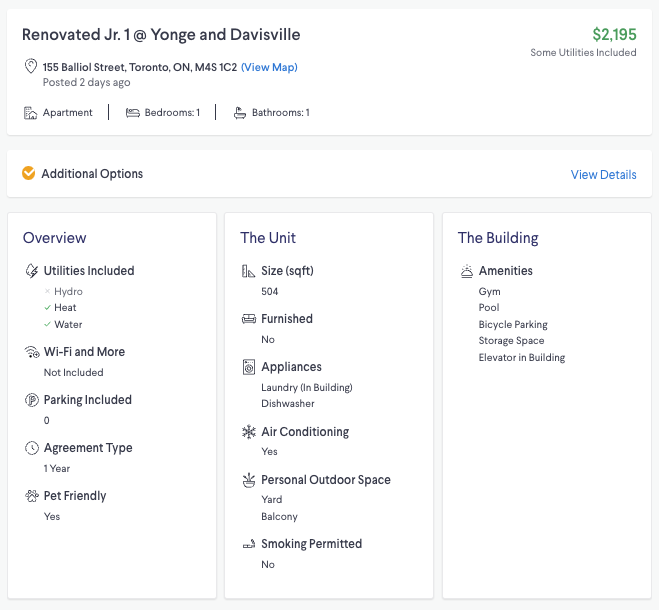

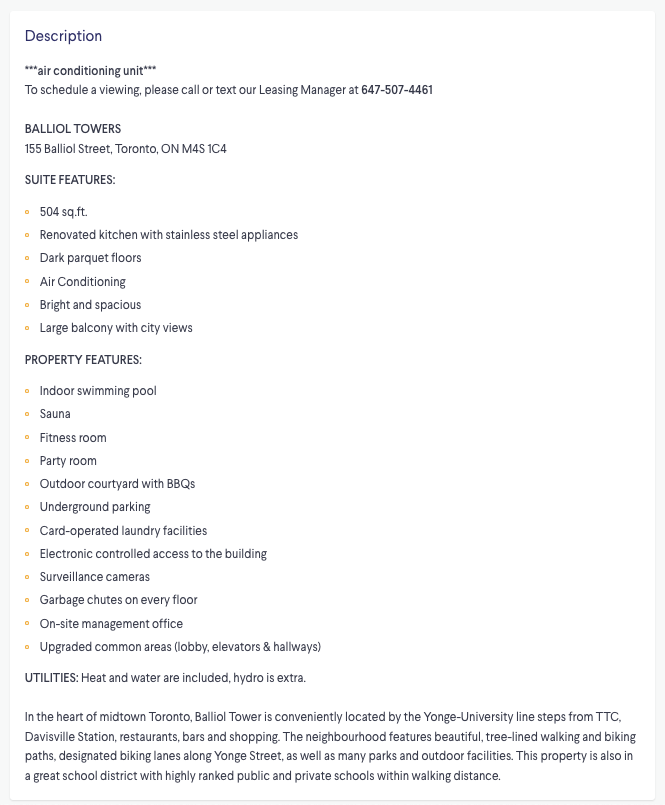

There are many features in a listing that are not formatted consistently in Kijiji and many other listing sites. Most of the information is found in the description which is hard to parse manually by hand or through code. This is where OpenAI's chat APIs were leveraged since its understanding of language is able to parse the features needed. The key is to prompt correctly. The code below shows the call to the OpenAI api to receive the features in JSON format.

In [ ]:
# NO NEED TO RUN

import openai
import configparser
import asyncio
import os
import json

config = configparser.ConfigParser()
dir = os.path.dirname(os.path.abspath(__file__))
config.read_file(open(os.path.join(dir, 'openai.config')))
API_KEY = config.get('API KEY', 'API_KEY')
openai.api_key = API_KEY
MAX_RETRIES = 100

async def parse_kijiji_posting(url):
  # gpt-3.5-turbo: $0.002 / 1K tokens generated
  retries = 0
  output = {}

  while True:
    try:
        chatCompletion = await openai.ChatCompletion.acreate(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": """ONLY RESPOND IN JSON. You are a data parser for real estate.
                Given an ambiguous blob of text scraped from the web, you will extract and return in JSON format the following fields:
                - address: string, Canadian address in this format: Address, City, Province 
                - rent: float, rent price in Candian Dollars
                - num_bedrooms: int, number of bedrooms
                - num_bathrooms: int, number of bathrooms
                - furnished: bool, if the unit comes furnished
                - utilities_included: bool, if hydro, wifi, water and heating is included then this field is true, else it's false.
                - in_unit_laundry: bool, if there is laundry in unit. If undeterminable, assume false
                - gym: bool, if there is a gym in the building. If undeterminable, assume false.
                - parking: bool, if the unit has parking available.
                - female_only: bool, if the unit is female only
                - area: int, area of unit in square foot
                
                If the address is not available, return an empty JSON. DO NOT add additional notes, only JSON."""},
                {"role": "user", "content": text},
            ]
        )

        # Successful try
        break
    except openai.error.RateLimitError as e: # In the free tier, OpenAI API has a rate-limit of 20 requests/min
        # Back off and retry
        if retries < MAX_RETRIES:
            print(f"Rate limited. Retrying in {15} seconds...")
            retries += 1
            await asyncio.sleep(15)
        else:
            print("Max retries exceeded. Aborting.")
            return output
    except Exception as e:
        print('Was not able to parse using openai: ', e)

  try:
    # Parse chat gpt output into a JSON object
    output = json.loads(chatCompletion['choices'][0]['message']['content'])
  except Exception as e:
    print(f'Did not receive a valid JSON for url {url}: ', e, )
    print('Chat output: ',
          chatCompletion['choices'][0]['message']['content'])

  return output

From the listing above, the following output was received from ChatGPT, along with other examples. The team chose to print the first 10 for comparison purposes after this section.

In [ ]:
# NEED TO RUN

import json

!wget https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/kijiji_links.txt
!wget https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/housing_data.json

with open('kijiji_links.txt', 'r') as f:
  kijiji_links = f.read().split('\n')

with open('housing_data.json', 'r') as f:
  housing_data = json.loads(f.read())

print(f'Example from above\nURL: https://www.kijiji.ca/v-apartments-condos/city-of-toronto/renovated-jr-1-yonge-and-davisville/1648486829\nDATA:\n{json.dumps(housing_data[3], indent=2)}\n=================')

print("\nPrinting first 10 datapoints")
for i, (url, data) in enumerate(zip(kijiji_links[:10], housing_data[:10])):
  print(f'#{i} URL: {url}\nDATA:\n{json.dumps(data, indent=2)}\n=================')

--2023-04-06 18:45:29--  https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/kijiji_links.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 313031 (306K) [text/plain]
Saving to: ‘kijiji_links.txt’

kijiji_links.txt    100%[===================>] 305.69K  --.-KB/s    in 0.004s  

2023-04-06 18:45:29 (66.4 MB/s) - ‘kijiji_links.txt’ saved [313031/313031]

--2023-04-06 18:45:29--  https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/housing_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.co

The data parsed from the postings are noisy and are often formatted inconsistently. This means some features may be mentione in some postings while not present in others, such as `area`. For almost all of the postings however, chatGPT has a high accuracy in extracting all of the relevant information.

Another consequence of the noisy data is the address either being unavailable or incomplete (i.e. only provides an intersection or a street). This is why a round of data cleaning is needed which will be elaborated below.

### 2.2.3 Parallelizing data scraping

When making a call to OpenAI's API, the program is blocked while waiting for a response from ChatGPT. To speed up the data acquisition, multiple calls to OpenAI were done simultaneously using Python's `asyncio` library. However, the free tier of OpenAI, which was used in this project, had a rate limit of 20 requests per minute so a simple rate limiter on the client side was implemented. This was done by sending an asynchronous request every 3 seconds and implementing a back off and retry in case the request is rate limited.

The code below shows how the code was parallelized:

In [ ]:
# NO NEED TO RUN

from kijiji_html_extractor import extract_kijiji_postings
from OpenAIParser.openai_parser import parse_kijiji_posting
from kijiji_html_extractor import extract_kijiji_postings
from tqdm import tqdm
import json
import asyncio
import argparse
import os
import time


async def main():
    start_time = time.time()
    parser = argparse.ArgumentParser()
    parser.add_argument("--skip_urls", action="store_true",
                        help="Skip extracting urls from Kijiji and use existing file")
    args = parser.parse_args()
    print(args)
    if not args.skip_urls:
        ad_links = extract_kijiji_postings()
    else:
        print("Skipping URL Extraction, reading from kijiji_links.txt")

        dir = os.path.dirname(os.path.abspath(__file__))

        with open(os.path.join(dir, 'kijiji_links.txt'), 'r') as f:
            ad_links = [line.strip() for line in f.readlines()]

    housing_data = []

    print(f"Processing {len(ad_links)} URLS")
    tasks = []
    for url in ad_links:
        task = asyncio.create_task(parse_kijiji_posting(url))
        tasks.append(task)
        await asyncio.sleep(3)

    results = await asyncio.gather(*tasks)
    for result in results:
        if result:
            housing_data.append(result)

    with open('housing_data.json', 'w') as f:
        f.write(json.dumps(housing_data, indent=4))

    end_time = time.time()

    print(
        f"Runtime: {end_time - start_time:.2f} seconds. Found {len(housing_data)} addresses")


asyncio.run(main())

## **2.3 Data Processing**

### **2.3.1 Data Cleaning**

After collecting the data, there were numerous data points that had incorrect or missing data for the features. All of these different methods and algorithms are found in the attached python code file named `raw_to_cleaned()`. One of the instances that was seen was that individual data points had incorrect addresses (no numbers included). Since the address is a crucial feature in calculating other attributes such as distance to campus, groceries and bus stops, the cleaning involved removing the data point if any issues were found. The coding implementation of this methodology includes checking if the address starts with a number of 0-9, if the data didn’t then the singular data point was removed from the set. Similarly, the cost of the rental unit is the most important feature according to the groups methodology resulting in all data points being deleted if the rent was 0 or empty. 

Aside from deleting data points to clean the data set, some logical assumptions were made for different features that had distinct values.  In particular, the number of bedrooms and bathrooms were assumed to be at least one in all of the singular data points. To implement this assumption within the code, the `num_bedrooms` and `num_bathrooms` feature values are checked and if they are equal to 0 or empty, the value of 1 is overwritten. Another assumption is that if any of the other feature booleans are not true, the values are manually set to false. This is due to the reasoning that some of these features might be empty as a result of the listing not mentioning the feature; however, in this case it is adequate to assume that the rental unit does not have the feature. 

The `raw_to_cleaned()` function is used to clean the data obtained from parsing web data. Specific rules can be seen below.

As an example, the first 10 datapoints from the previous section will be cleaned using the rules below.

In [ ]:
# NEED TO RUN

import json
import re
import os

!wget https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/housing_data.json

with open('housing_data.json', 'r') as f:
  housing_data = json.loads(f.read())

def raw_to_cleaned(houses):
    print(f"Cleaning {len(houses)} datapoints")
    # Remove all data that does not have all of the required keys:
    required_keys = ['address', 'rent', 'num_bedrooms', 'num_bathrooms', 'furnished',
                     'utilities_included', 'in_unit_laundry', 'gym', 'parking', 'female_only', 'area']
    houses = [d for d in houses if all(field in d for field in required_keys)]

    # Remove house that its address dosent start with 0-9
    regex = re.compile(r"^[^0-9]")
    houses = [house for house in houses if house["address"]
              is not None and not regex.match(house["address"])]

    # Remove house that does not have rent
    houses = [d for d in houses if isinstance(
        d['rent'], float) and d['rent'] > 0]

    # If the utilities field is an object, collapse it into one boolean field.
    for h in houses:
        if isinstance(h['utilities_included'], dict):
            collapsed_bool = True
            for _, v in h['utilities_included'].items():
                if v != True:
                    collapsed_bool = False
                    break
            h['utilities_included'] = collapsed_bool

    # Default values for dicts (aka assumptions)
    for h in houses:
        if h['num_bedrooms'] == 0 or h['num_bedrooms'] is None:
            h['num_bedrooms'] = 1

        if h['num_bathrooms'] == 0 or h['num_bathrooms'] is None:
            h['num_bathrooms'] = 1

        if h['furnished'] != True:
            h['furnished'] = False

        if h['in_unit_laundry'] != True:
            h['in_unit_laundry'] = False

        if h['gym'] != True:
            h['gym'] = False

        if h['parking'] != True:
            h['parking'] = False

        if h['female_only'] != True:
            h['female_only'] = False


    # No need to save the file in colab
    # dir = os.path.dirname(os.path.abspath(__file__))
    # with open(os.path.join(dir, '../Processing/housing_data_cleaned.json'), 'w') as f:
    #     f.write(json.dumps(houses, indent=4))
    print(f"Finished cleaning data, left with {len(houses)} datapoints")

    return houses

cleaned_data = raw_to_cleaned(housing_data[:10])
print(json.dumps(cleaned_data, indent=2))

--2023-04-06 18:44:23--  https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/d08b5816e22f86408d4cef5b6eb436ae04f3fa8e/Acquisition/housing_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 851947 (832K) [text/plain]
Saving to: ‘housing_data.json’

housing_data.json   100%[===================>] 831.98K  --.-KB/s    in 0.006s  

2023-04-06 18:44:23 (142 MB/s) - ‘housing_data.json’ saved [851947/851947]

Cleaning 10 datapoints
Finished cleaning data, left with 4 datapoints
[
  {
    "address": "1577 Lawrence Ave W, Toronto, ON",
    "rent": 2319.0,
    "num_bedrooms": 1,
    "num_bathrooms": 1,
    "furnished": false,
    "utilities_included": true,
    "in_unit_laundry": false,
    "gym": false,
    "parking": true,
    "female_

From the 10 datapoints initially, only 4 were left since the other 6 did not have complete addresses. Also, all of the features now have a value except for area since it is hard to assume an area for a posting.

### **2.3.2 Feature Engineering**

Feature engineering, on the other hand, involves creating new features from existing data that may be more predictive or informative for a specific machine learning task. Examples of feature engineering might include creating interactions between existing features, transforming features using mathematical functions, or using domain knowledge to create new features that capture important aspects of the data.

In our project, we used feature engineering to build additional variables that may potentially increase the performance of our machine learning models. We specifically constructed a tag that records the closest distance from each rental property to the University of Toronto's main campus, which we hypothesised may be connected with the rental price. In addition, we designed a tag that computes the closest distance from each rental property to the nearest point of interest (POI), grocery stores as an example, as we suspected that proximity to grocery stores may have an effect on housing pricing. By include these traits in our dataset, we intended to collect extra information that may potentially increase the accuracy of our predictions.

We undertook feature engineering prior to data transformation so that we could interact with and manage our data in a more efficient and understandable manner. Because we were using JSON for data collecting and cleaning, it was simpler to save intermediate findings as JSON objects rather than converting them to a DataFrame too soon. We were able to avoid time costly conversions and expedite our workflow by waiting until we were ready to start our machine learning algorithms. This method also allowed us to iterate and experiment with alternative feature engineering strategies without having to transfer our data back and forth between different formats on a regular basis.

The `dist_to_campus()` helper function computes the distance to the university campus from each housing address. This function utilize `osmnx`, a library that allows downloading geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks. This allow the team to compute real-world street distances rather than euclidian distances which is not a good estimation in mapping system.

*   Input `addresses`: `list` of `string` addresses
*   Input `plot`: `bool` variable, whether to plot the visualization map
*   Output `distances`: `list` of `double` in km showing distance to each given housing address.


In [ ]:
# NO NEED TO RUN

import osmnx as ox
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

WAIT_SEC = 1.5
TIMEOUT = 5

def dist_to_campus(addresses,plot):
    # Get the coordinates of university campus
    geolocator = Nominatim(user_agent="my_app")
    campus_location = geolocator.geocode("University of Toronto, Toronto, Ontario, Canada", timeout=TIMEOUT)
    campus_coords = (campus_location.latitude, campus_location.longitude)
    campus_graph = ox.graph_from_point(
        center_point = campus_coords,
        dist = 8000,
        network_type = "walk",
        simplify = True)
    campus_id = ox.distance.nearest_nodes(
        G = campus_graph,
        X = campus_coords[1],
        Y = campus_coords[0])
    if plot:
        fig0,ax0 = ox.plot.plot_figure_ground(
            G = campus_graph,
            show = False,
            close = False)
    # Calculate the road distance from each address to the campus
    print("Calculating distance to campus for each house")
    distances = []
    for address in tqdm(addresses):
        time.sleep(WAIT_SEC)
        house_location = geolocator.geocode(address, timeout=TIMEOUT)
        if house_location is None:
            distances.append(None)
        else:
            house_coords = (house_location.latitude, house_location.longitude)
            house_id = ox.distance.nearest_nodes(
                G = campus_graph,
                X = house_coords[1],
                Y = house_coords[0])
            route = ox.distance.shortest_path(
                G = campus_graph,
                orig = house_id,
                dest = campus_id,
                weight = "length"
            )
            distance = sum(ox.utils_graph.get_route_edge_attributes(
                G = campus_graph,
                route = route,
                attribute = "length"
            ))
            distances.append(round(distance/1000,2))
            if plot:
                fig0,ax0 = ox.plot.plot_graph_route(
                    G = campus_graph,
                    route = route,
                    ax = ax0,
                    route_color = "blue",
                    show = False,
                    close = False)
    if plot:
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.show()
    return distances


Similar to `dist_to_campus()`, the `dist_to_POI()` helper function is used for computing distance features as well. However, it allows the team to obtain the closest distance to a list of point of interests (POIs) for each housing address. Ultimately, we can obtain information on whether a given address is close to a grocery store or bus stop in the city.

*   Input `addresses`: `list` of `string` addresses
*   Input `plot`: `bool` variable, whether to plot the visualization map
*   Input `option`: `string` variable, whether to compute closet distance to `"grocery"` or `"bus_stop"`
*   Output `distances`: `list` of `double` in km showing distance to each given housing address.

In [ ]:
# NO NEED TO RUN

import osmnx as ox
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import time

WAIT_SEC = 1.5
TIMEOUT = 5

def dist_to_POI(addresses,plot,option):
    # Get the coordinates of university campus
    geolocator = Nominatim(user_agent="my_app")
    campus_location = geolocator.geocode("University of Toronto, Toronto, Ontario, Canada", timeout=TIMEOUT)
    campus_coords = (campus_location.latitude, campus_location.longitude)
    campus_graph = ox.graph_from_point(
        center_point = campus_coords,
        dist = 8000,
        network_type = "walk",
        simplify = True)

    # Import addresses and find node IDs
    print("Getting POI IDs")
    if (option == "grocery"):
        with open('Processing/grocery_addresses.json', 'r') as f:
            input_data = json.load(f)
    elif (option == "bus"):
        with open('Processing/bus_stop_addresses.json', 'r') as f:
            input_data = json.load(f)
    else:
        print("Specified option is not valid")
        return
    
    POIs = input_data['addresses']
    POI_ids = []
    for POI in tqdm(POIs):
        time.sleep(WAIT_SEC)
        POI_location = geolocator.geocode(POI, timeout=TIMEOUT)
        if POI_location is not None:
            POI_coords = (POI_location.latitude, POI_location.longitude)
            POI_id = ox.distance.nearest_nodes(
                G = campus_graph,
                X = POI_coords[1],
                Y = POI_coords[0])
            POI_ids.append(POI_id)

    if plot:
        fig0,ax0 = ox.plot.plot_figure_ground(
            G = campus_graph,
            show = False,
            close = False)
    
    # Calculate the road distance from each address to the closest POI
    print("Calculating distance to closest POI for each house")
    distances = []
    for address in tqdm(addresses):
        time.sleep(WAIT_SEC)
        house_location = geolocator.geocode(address, timeout=TIMEOUT)
        if house_location is None:
            distances.append(None)
        else:
            house_coords = (house_location.latitude, house_location.longitude)
            house_id = ox.distance.nearest_nodes(
                G = campus_graph,
                X = house_coords[1],
                Y = house_coords[0])
            routes = []
            for POI_id in POI_ids:
                route = ox.distance.shortest_path(
                    G = campus_graph,
                    orig = house_id,
                    dest = POI_id,
                    weight = "length")
                routes.append(route)
            shortest_distance = float('inf')
            for route in routes:
                distance = sum(ox.utils_graph.get_route_edge_attributes(
                    G = campus_graph,
                    route = route,
                    attribute = "length"))
                distance = round(distance/1000,2)
                if distance < shortest_distance:
                    shortest_distance = distance
                    shortest_route = route
            distances.append(shortest_distance)

            if plot:
                fig0,ax0 = ox.plot.plot_graph_route(
                    G = campus_graph,
                    route = shortest_route,
                    ax = ax0,
                    route_color = "red",
                    show = False,
                    close = False)
    if plot:
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.show()
    return distances


Main code of the "Processing Module", reads `housing_data.json` obtained from the web parsing algorithm from "Acquisition Module", pass it to the `raw_to_cleaned()` cleaning algorithm which cleans the data and save as `housing_data_cleaned.json` within the function. Import `housing_data_cleaned.json` add tags to the data, including the distance to campus and distance to other point of interests. The final result is saved as `housing_data_processed.json`.

In [ ]:
# NO NEED TO RUN

import json
import os

# Load the input data from JSON file
dir = os.path.dirname(os.path.abspath(__file__))
with open(os.path.join(dir, '../Acquisition/housing_data.json'), 'r') as f:
    houses_raw = json.load(f)

# clean the data and save as json
houses_cleaned = raw_to_cleaned(houses_raw)

# load cleaned data
with open(os.path.join(dir, '../Processing/housing_data_cleaned.json'), 'r') as f:
    houses_cleaned = json.load(f)

# Extract the addresses from the input data (same order)
addresses = [house['address'] for house in houses_cleaned]

# Call functions with the addresses as input, VERY computational expensive
campus_distances = dist_to_campus(addresses, False)
grocery_distances = dist_to_POI(addresses, False, "grocery")
# bus_stop_distances = dist_to_POI(addresses,False,"bus")

# Use a list comprehension to create a new list of objects with "distance_to_POI" keys added
houses_processed = [
    {**house, "distance_to_POI": {
        "campus": campus_distances[i],
        "grocery": grocery_distances[i],
        # "bus_stop": bus_stop_distances[i]
        "bus_stop": "pending"
    }} for i, house in enumerate(houses_cleaned)
]

with open(os.path.join(dir, 'housing_data_processed.json'), "w") as outfile:
    # Write the JSON object to the file
    json.dump(houses_processed, outfile)


The resulting `housing_data_processed.json` consists of all processed data where the noises are drastically minimized and relevant distances features were added. The example below prints the first element of the file. 

Note that the `bus_stop` tag within the `distance_to_POI` group is labeled as "pending" at the moment, although the helper function is capable of calculating the distance to the cloest point of interest with any given list of POIs, but  the group have not yet find a reliable method to obtain the public transit stops addresses for the entire GTA. This is something planned for future developments.

In [ ]:
# NEED TO RUN
import json
import wget
!wget https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/main/Processing/housing_data_processed.json

with open('housing_data_processed.json', 'r') as f:
  housing_data_processed = json.loads(f.read())

print(json.dumps(housing_data_processed[1], indent=2))

--2023-04-06 18:42:05--  https://raw.githubusercontent.com/ZitherBai/Waterloo-Housing-Price-Predictor/main/Processing/housing_data_processed.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471200 (460K) [text/plain]
Saving to: ‘housing_data_processed.json.2’

housing_data_proces 100%[===================>] 460.16K  --.-KB/s    in 0.005s  

2023-04-06 18:42:06 (90.8 MB/s) - ‘housing_data_processed.json.2’ saved [471200/471200]

{
  "address": "1577 Lawrence Ave W, Toronto, ON",
  "rent": 2789.0,
  "num_bedrooms": 2,
  "num_bathrooms": 1,
  "furnished": false,
  "utilities_included": true,
  "in_unit_laundry": false,
  "gym": false,
  "parking": true,
  "female_only": false,
  "area": 962,
  "distance_to_POI": {
    "campus": 11.08,
    "grocery": 8.36,
  

An example output of the `dist_to_campus()` function when the `plot` option is set to `True` is shown below. The first 10 addresses of `housing_data_processed.json` each connected with the University of Toronto main campus is annotated as the blue line segments. The white lines indicate real-life roads that students can walk or drive.

Note that this demostrate a potential outlier in the data, the house marked on the top left corner of the mapped region may not have a lesser housing price (according to the calculated distance) even its far away from the UofT campus, students may rent that apartment to attend a different University.

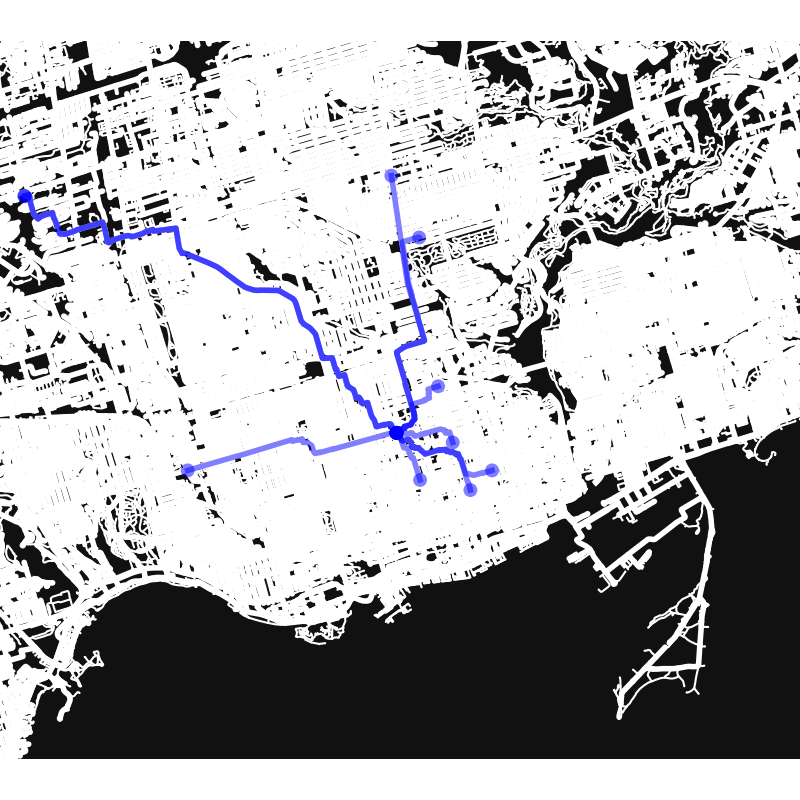

An example output of the `dist_to_POI()` function when the `plot` option is set to `True` is shown below. The first 10 addresses of `housing_data_processed.json` each connected with its closest grocery store is annotated as the red line segments.

Note that this also demostrate a potential outlier in the data, the house marked on the top left corner of the mapped region is mapped towards its closest grocery store towards the south. This is unlikely in real-life as there might be a closer grocery store locations that the group have missed in the lookup list. The group have already attempted its best to include as many local grocery store locations as possible but it is not possible to include all of the GTA region, especially when there are new postings (housing addresses) available.

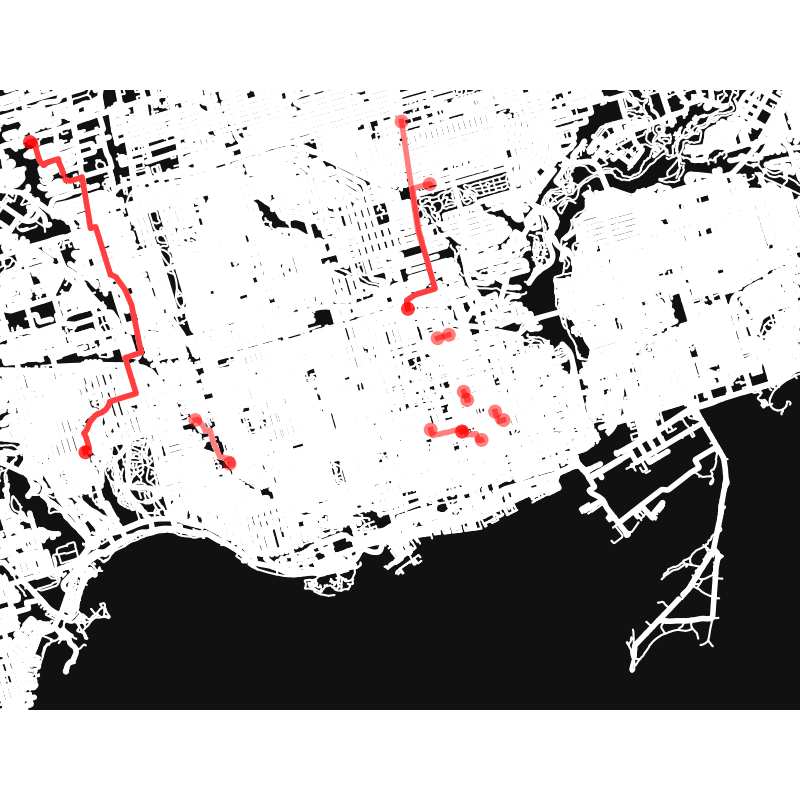

### **2.3.3 Data Transformation**

Data transformation involves converting data from one format or structure to another, usually to make it easier to work with or to prepare it for analysis. Examples of data transformation might include converting dates to a standardized format, scaling numerical data to a similar range, or encoding categorical data as numerical values.

Before converting the JSON array to a dataframe, there are a few extra steps that need to be done for processing the input data.

- First, the `distance_to_POI` field (an embedded dictionary that includes the distances to different points of interest) should be expanded into the format of `distance_to_POI:<Place Name>`. This step is necessary because each cell in the dataframe table should only contain primitive data types rather than an object.

- Second, to prevent the linear regression model provided by sklearn from giving errors, it is required to convert all the boolean values to numeric values. The detailed implementation is included in the `preprocess_dataset()` function below.

In [ ]:
# NO NEED TO RUN

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def new_section(arg_title):
    print(" ")
    print(" ")
    print("- - - - - - - - - - " + arg_title + " - - - - - - - - - -")
    print(" ")

# Create a dataframe using a JSON file
new_section("Input Loading")
with open('housing_data_processed.json') as f:
    data = json.load(f)
print("len(data):", len(data))
print("data[0]:", data[0])

# Pre-process the data:
new_section("Data Pre-processing")
# 1. Unwrap embedded dictionaries
# 2. Convert booleans to numeric values (for model training purposes)
def preprocess_dataset(arg_data):
    i_row = 0
    while i_row < len(arg_data):
        original_features = list(arg_data[i_row].keys())
        for feature in original_features:
            # Convert boolean values to numeric values:
            # * If we keep the booleans -> "TypeError: float() argument must be a string or a number"
            # * If we convert booleans to strings -> "ValueError: could not convert string to float: None"
            if feature in ['furnished', 'utilities_included', "in_unit_laundry", "gym", "parking", "female_only"]:
                if arg_data[i_row][feature] == True:
                    arg_data[i_row][feature] = 1
                elif arg_data[i_row][feature] == False:
                    arg_data[i_row][feature] = 0
                elif arg_data[i_row][feature] == None:
                    arg_data[i_row][feature] = -1

            # Expand the `distance_to_POI` field:
            if feature == "distance_to_POI":
                for poi in arg_data[i_row][feature]:
                    if poi != "bus_stop": # Ignores "bus_stop"
                        new_key = feature + ":" + poi
                        arg_data[i_row][new_key] = arg_data[i_row][feature][poi]
        i_row += 1
    # print("arg_data[2]:", arg_data[2])
    return arg_data

# Create a dataframe and drop unwanted columns:
df = pd.DataFrame(preprocess_dataset(data)).drop(columns=["address", "distance_to_POI"])

## **2.4 Data Summary**

This included developing tables and charts that displayed critical insights including the distribution of rental costs across different neighbourhoods and the link between rental pricing and variables like the number of bedrooms, bathrooms, and square footage.

How the following code process the dataframe is that, it will replace all the `None` values with the average value of that column. For the `area` column specifically, since it has both `0` (which does not make sense) and `None` values, the code replaces both `0` and `None` with the average area computed.

In [ ]:
# NO NEED TO RUN

new_section("Dataframe Overview")
print("df.head(5):", df.head(5))
print("Shape & Dimension:", df.shape, df.ndim)
print("Info:", df.info())

# For selected columns, replace `None` values with the column average:
for column in ["rent", "num_bedrooms", "num_bathrooms", "area", "distance_to_POI:campus", "distance_to_POI:grocery"]:
    # Handle `area: 0` and `area: None`:
    if column == "area":
        df.loc[df[column] < 1, column] = None
    col_mean = round(df[column].mean())
    df[column].fillna(col_mean, inplace=True)

print("df.head(5):", df.head(5))
print("Shape & Dimension:", df.shape, df.ndim)
print("Info:", df.info())

## **2.5 Data Visualization**

The Visualization section of the code generates two plots:

1. a histogram that shows the distribution of the prices in the dataset, and
2. a combined plot that consists of subplots, where each subplot is a scatter plot showing the correlation between one particular feature and the price.


In [ ]:
# NO NEED TO RUN

# Price distribution:
new_section("Visualization")
plt.hist(df['rent'], bins=20, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Distribution')
plt.tight_layout()
plt.show()

# Overview: Show scatter plots of all features against the price
fig = plt.figure(figsize=(20, 10))
i_plot = 1
for feature in df.columns:
    if (
        feature in ['num_bedrooms', 'num_bathrooms', 'area']
        or feature in ['furnished', 'utilities_included', "in_unit_laundry", "gym", "parking"]
        or "distance_to_POI:" in feature
    ):
        axes = fig.add_subplot(3, 4, i_plot)
        plt.scatter(df[feature], df['rent'])
        axes.set_xlabel(feature)
        axes.set_ylabel("Price")
        axes.set_title("Price vs." + feature)
        i_plot += 1
plt.show()

By running the code above, the follow two plots can be obtained easily.

- How the prices are distributed:

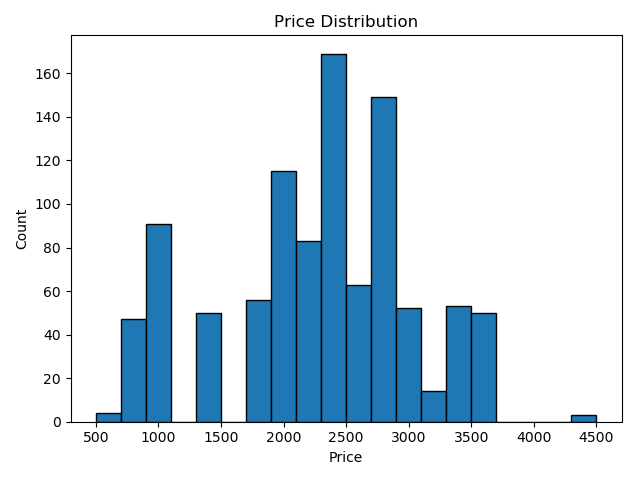

- The correlation of each feature and the price:

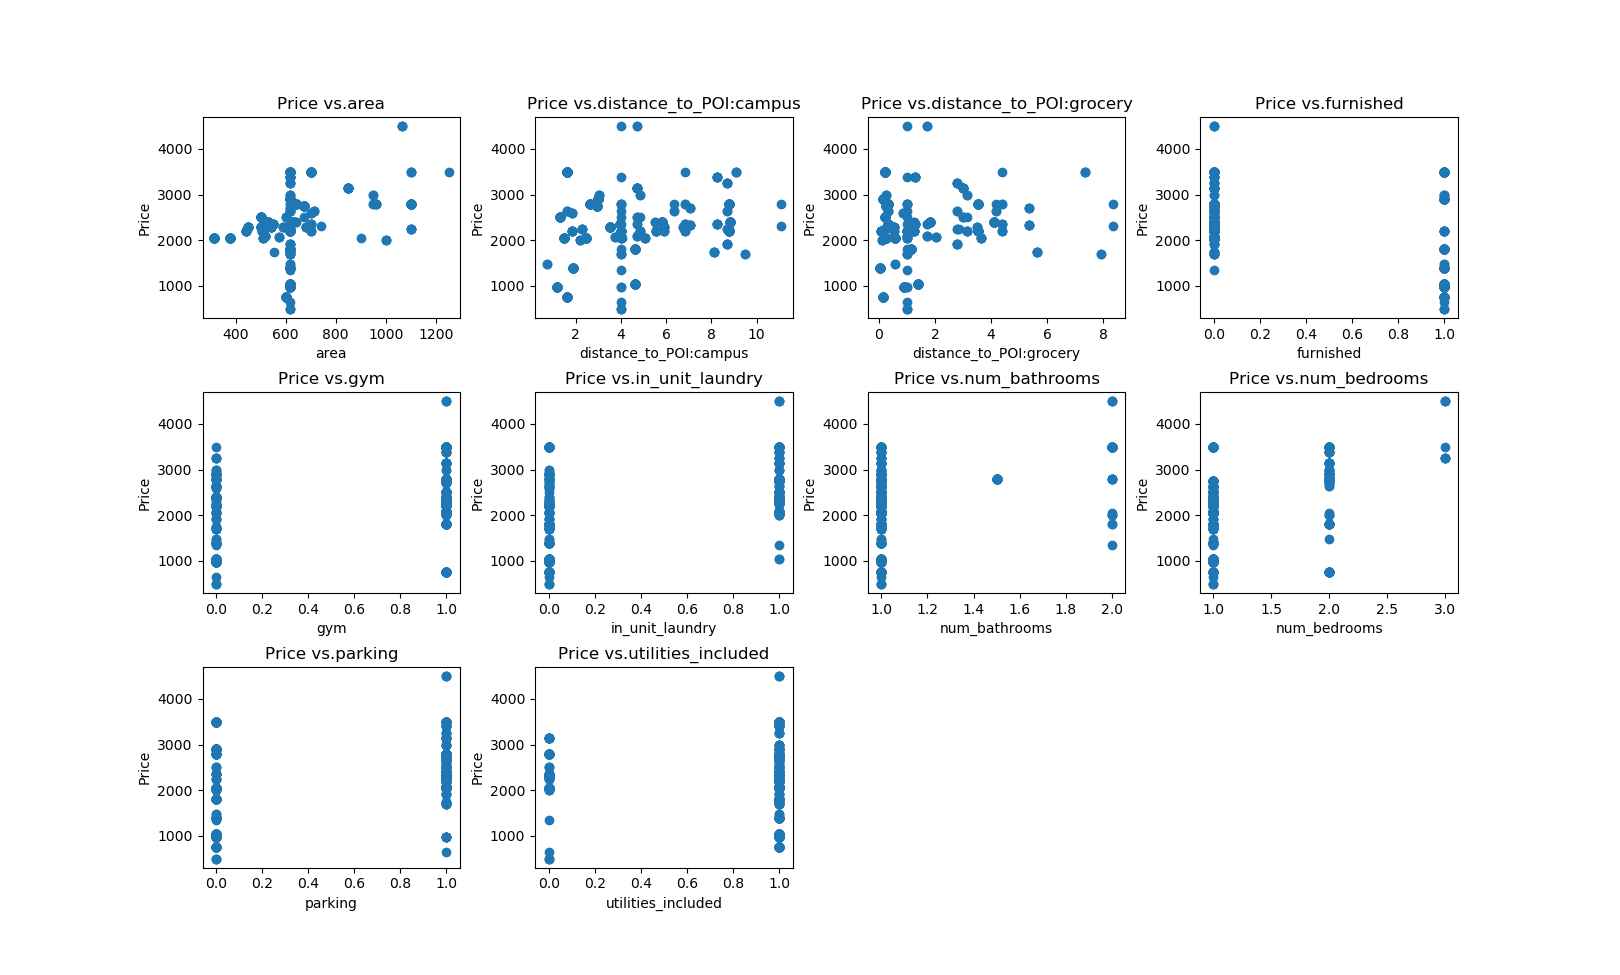

In the correlation plot above, it is worth mentioning that boolean features such as `in_unit_laundry` will either be `True` (converted to `1`) or `False` (converted to `0`). Such conversions are necessary because when training the regression model, the data type of each feature needs to be numerical. The implementation of the conversion is included in the `preprocess_dataset()` function in 2.3.3.

# **3. Machine Learning**

## **3.1 Algorithm**

### **3.1.1 Linear Regression Model - Standard**

The first attempt of creating an algorithmn to attempt to provide a solution to the problem included utilizing a simple linear regression model. In the code below, it can be seen that the library sklearn.linear_model is utilized to implement the simple linear regression model.

After the code was implemented for the simple linear regression case and tested on the cleaned data set, the performance was recorded and will be discussed. Although the results of the algorithm may have been able to predict the rental prices, the group wanted to experiment with other linear regression models to compare the performances. When comparing different types of models, the most accurate one for the use case can be found and implemented in the final completed tool. As a result, the following linear regression models were tested and imported from Scikit Learn including Ridge, Lasso and ElasticNet.

As a recommendation from the TAs, the various algorithms were all explored in detail; however, the parameter tuning was only performed on a single variation of the linear regression model. To decide which variation would produce the best results, a flowchart was consulted from the Scikit Learn website. A portion of the flow chart that outlines linear regression models can be seen below,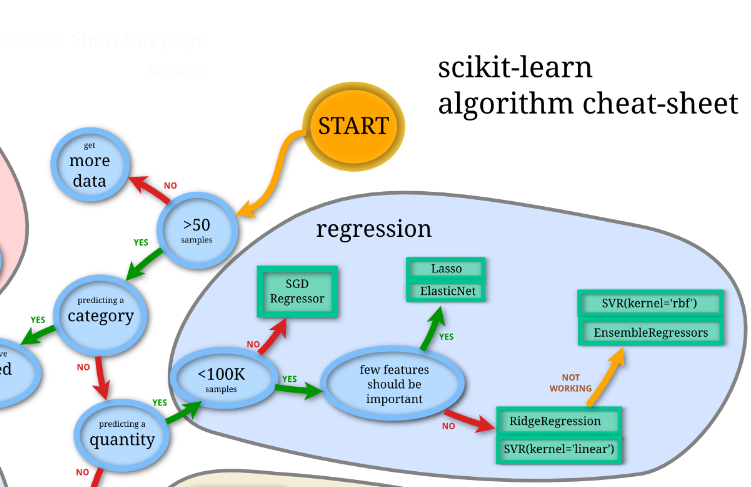

When referring to the flowchart, it describes that the Ridge regression model should be used if few features should be important. In the context of the problem, all features can be considered important since there are not a significantly large amount of distinct features. As a result, parameter tuning would be performed for the ridge regression model and the other two models of Lasso and ElasticNet would be explored. 




### **3.1.2 Linear Regression Model - Ridge [2]**

The first alternative linear regression model that was tested included the Ridge model. To better understand the algorithm it is important to look at the objective function that is being minimized:

$$||y - Xw||_2^2 + \alpha ||w||_2^2$$

When looking at the equation, the w is a vector containing all of the coefficients of the weights in the linear regression model. Within the Ridge linear regression model, there is an alpha parameter that is incorporated in the objective function that can be varied. An additional note is that if the alpha parameter was set to zero, then the equation would be reduced back into a normal linear regression model. It was discovered that a parameter value of alpha is common in different implementations of linear regression resulting in multiple values of alpha being run for unique regression models. This parameter tuning of alpha was crucial in discovering the impact the parameter had on the performance of the model, ending up with 5 different alpha values being tested across the three types of specialized regression models. After doing some research, it was concluded that high values of alpha correspond with stronger regularization in the model or higher smoothness contrast. In many instances, it was seen that alpha was set to values of around as high as 20 resulting in alpha values of 0.1, 1, 3, 10, 20, 50, 100, 1000 being tested.

### **3.1.3 Linear Regression Model - Lasso [3]**




In the case of the Lasso linear regression model, the optimization function changes significantly. The objective function is defined as follows:

$$\frac{1}{2n_{samples}} ||y - Xw||_2^2 + \alpha ||w||_1$$

It is now seen that the objective function incorporates the number of samples and the alpha parameter. A similar approach that was used in the Ridge linear regression was used to assess the performance of the Lasso variation. It is known that regularization improves the conditioning of the problem and reduces variance of the estimates with large values of alpha corresponding to stronger regularization. To stay consistent with the process of varying alpha across the linear regression variations, the same eight alpha values would be tested for the Lasso model. For the Lasso model, it is suitable in cases where there is a significant number of features and will eliminate unnecessary ones. When the Lasso algorithm was run on the dataset, it was noticed that almost half the features were eliminated depending on the selected alpha values leading to incorrect results. An example of how the code would be modified to include the Lasso regression is shown below,


### **3.1.4 Linear Regression Model - ElasticNet [4]**

The last linear regression model that was explored for the problem was ElasticNet. The ElasticNet objective function is increasingly more complex and utilizes different ratios and is defined as:

$$\frac{1}{2n_{samples}} ||y - Xw||_2^2 + \alpha \text{ } l1_{ratio} ||w||_1 + 0.5 \text{ } \alpha \text{ } (1 - l1_{ratio}) ||w||_2^2$$

A very interesting observation is that the objective function combines aspects of both Ridge and Lasso. Similarly to all the other linear regression variations, the parameter that is required to be tuned is alpha. The same alpha values would be run for theElasticNet algorithm on the housing data and the performance of the model was tested to see the accuracy of classification. It is important to note that ElasticNet was not actually tested on the dataset but sample code was created as seen below on how the variation would be run for future implementations.


### **3.1.5 Training and Testing the Ridge Regression Model**

As discussed in 3.1.1 and 3.1.2, the group decided to use the Ridge Regression model to predict the housing price.

The following code separates the label ("rent") from the features by dropping the "rent" column of the dataframe. It sets 40% of the data as test dataset, meaning 60% of the data will be used for training.

In [ ]:
# NO NEED TO RUN

# Training dataset and testing dataset:
new_section("Model Training")
df_rent_dropped = df.drop("rent", axis=1)
df_train, df_test, price_train, price_test = train_test_split(df_rent_dropped, df["rent"], test_size=0.4)
print("df_train.head(5)", df_train.head(5))
print("Shape & Dimension:", df_train.shape, df_train.ndim)

# isnan() should always return false; isfinite() should always be true.
# print(np.any(np.isnan(df_train)), np.any(np.isfinite(df_train)), np.any(np.isnan(price_train)), np.any(np.isfinite(price_train)))

The `get_lin_reg_model()` function below implements the standard, Lasso, and Ridge linear regression models. By specifying "Ridge" and the alpha value, this function will return an instance of the Ridge regression model. The alpha values that will be tested with were initially `[0, 0.1, 1, 10, 100, 1000]`, but `3`, `20`, and `50` were added to the list to more precisely tune the ideal alpha value.

In [ ]:
# NO NEED TO RUN

def get_lin_reg_model(arg_model_type, arg_alpha=None):
    lin_reg_obj = None
    if arg_model_type == "Standard":
        lin_reg_obj = LinearRegression()
    elif arg_model_type == "Lasso":
        if arg_alpha == None:
            raise Exception("Lasso(): Please specify the Alpha value!")
        lin_reg_obj = Lasso(arg_alpha)
    elif arg_model_type == "Ridge":
        if arg_alpha == None:
            raise Exception("Ridge(): Please specify the Alpha value!")
        lin_reg_obj = Ridge(arg_alpha)
    return lin_reg_obj

# Train the model using different alpha values:
for alpha_ridge in [0, 0.1, 1, 3, 10, 20, 50, 100, 1000]:
    lin_reg_obj = get_lin_reg_model("Ridge", alpha_ridge)
    lin_reg_obj.fit(df_train, price_train)
    correlations = pd.DataFrame(lin_reg_obj.coef_, df_rent_dropped.columns, columns = ['Coeff'])
    print("Correlations:", correlations)

    # Test the model:
    new_section("Evaluating Model Accuracy")
    predictions = lin_reg_obj.predict(df_test)
    plt.clf() # Clears the figrue
    plt.scatter(price_test, predictions)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.plot(np.linspace(0,5,100), np.linspace(0,5,100), '-r')
    # plt.show()
    plt.savefig('actual_vs_predicted-alpha=' + str(alpha_ridge) + '.png')

    # Visualize the residuals:
    plt.clf() # Clears the figrue
    plt.hist(price_test - predictions, edgecolor='black')
    plt.ylabel("Count")
    plt.xlabel("Residual")
    # plt.show()
    plt.savefig('residuals-alpha=' + str(alpha_ridge) + '.png')

    print(
        "Alpha: " + str(alpha_ridge),
        "Mean absolute & squared error:",
        metrics.mean_absolute_error(price_test, predictions),
        metrics.mean_squared_error(price_test, predictions)
    )
    # np.sqrt(metrics.mean_squared_error(price_test, predictions))

For each alpha value listed above, the program will generate and save a residual distribution plot, where the ideal distribution plot should be symmetric around 0. It also prints the mean absolute error and mean squared error into the console, and the appropriate alpha value should result in small errors. The corresponding plots and errors for each of these alpha values are shown below in Section 3.2 Results.

## **3.2 Results**

### **3.2.1 Residual Plots**

After running the normal linear regression model and the Ridge variation, plots of the residual errors were outputted and used to test the prediction accuracy. In addition, the sum of squared error and mean absolute error were calculated as a metric to better understand the performance of the machine learning algorithms. The following residual plots can be seen for varying alpha values and the normal linear regression model.
 



Normal Linear Regression Model:


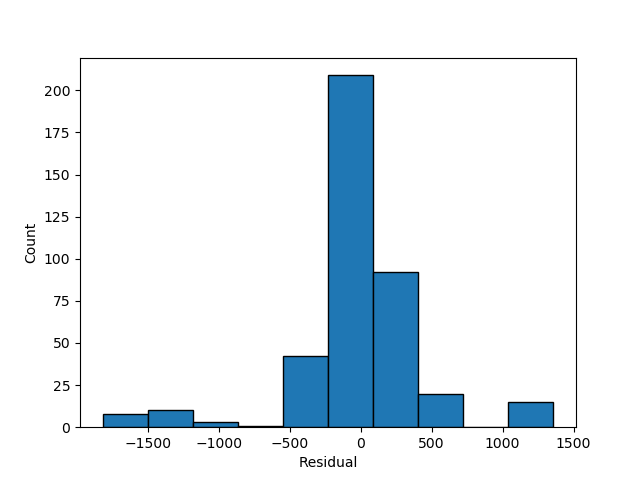


Ridge With Alpha Equals 0.1:

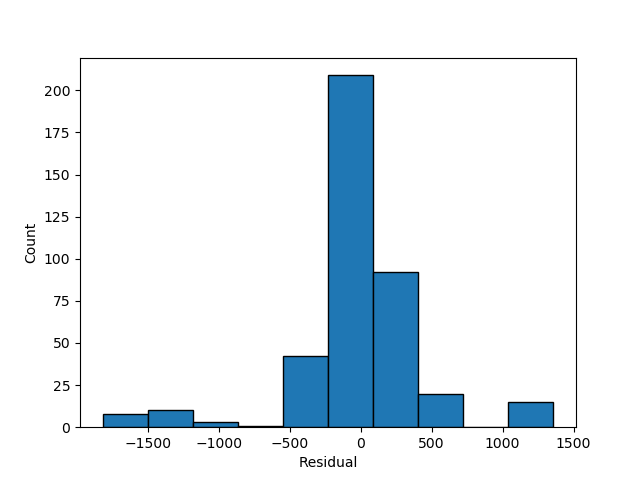


Ridge With Alpha Equals 1:

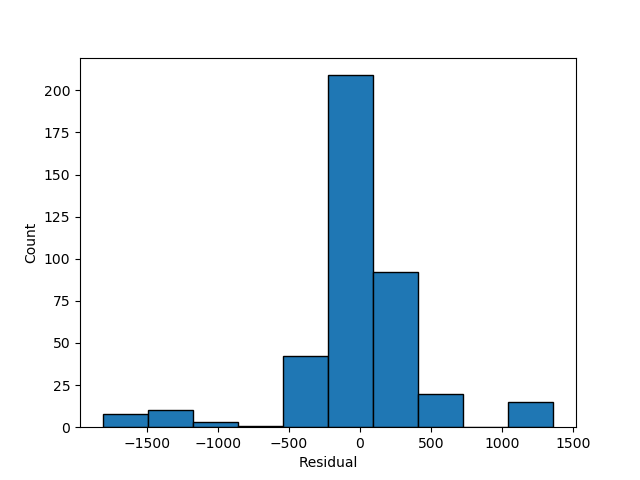

Ridge With Alpha Equals 3:

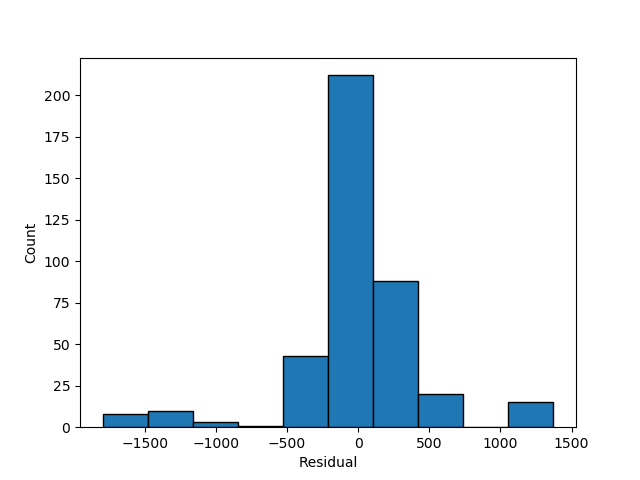:

Ridge With Alpha Equals 10:

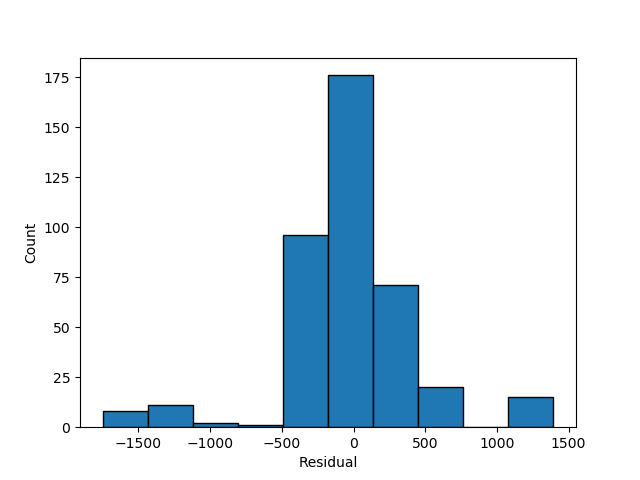

Ridge With Alpha Equals 20:

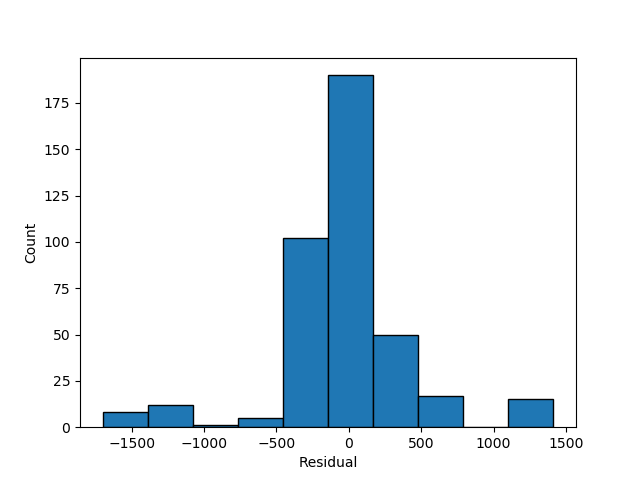

Ridge With Alpha Equals 50:

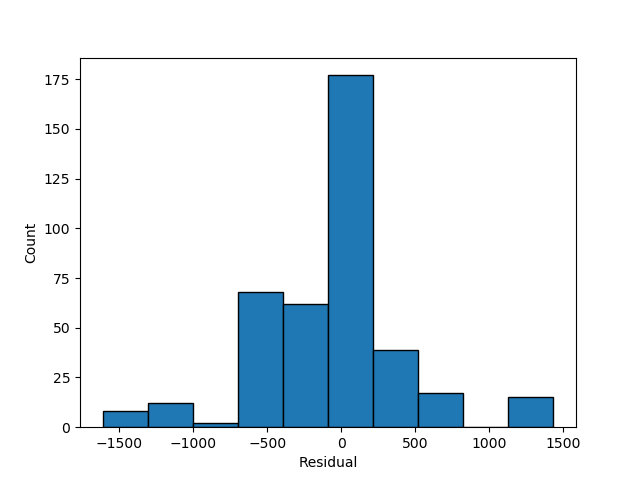

Ridge With Alpha Equals 100:

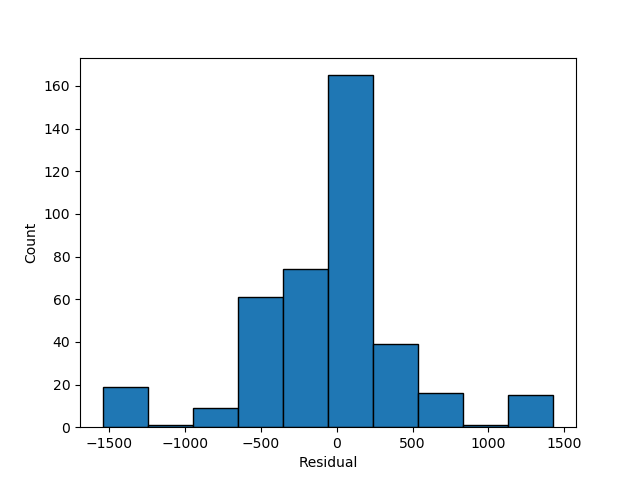

Ridge With Alpha Equals 1000:

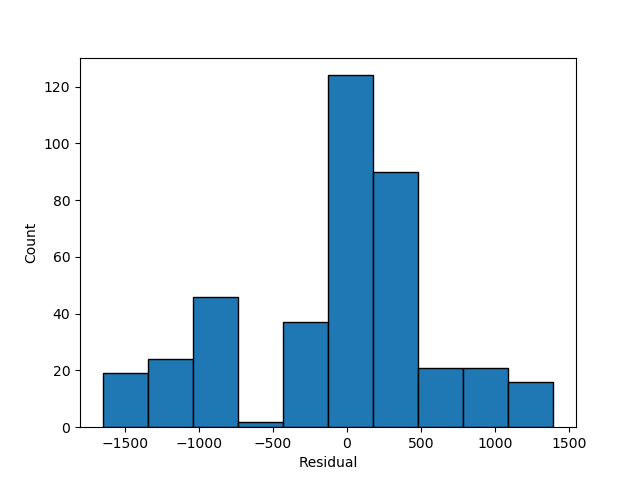



Although the residual plots give valuable insights regarding the prediction algorithms, it is important to look at the error performance metrics as well. The following table has all of the error metrics summarized for the normal linear regression and Ridge variation models.

| Type of Regression | Mean Absolute Error | Squared Error |
| ------------------ | ------------------- | ------------- |
| Normal Linear      | 283.7               | 239748.8      |
| Alpha 0.1          | 283.8               | 239738.3      |
| Alpha 1            | 284.7               | 239678.7      |
| Alpha 3            | 287                 | 239736.3      |
| Alpha 10           | 294.4               | 241226.1      |
| Alpha 20           | 304                 | 245042.2      |
| Alpha 50           | 325.9               | 259334.7      |
| Alpha 100          | 351.7               | 281757.7      |
| Alpha 1000         | 477.2               | 429087.2      |

### **3.2.2 Correlation Coefficients**

The correlation coefficients were also calculated for the normal linear regression case with `alpha = 0` and the Ridge variation cases with `alpha = 0, 0.1, 1, 3, 10, 20, 50, 100` as summarized below.

`Alpha=0`, `Mean Absolute Error=283.70018822093544`, `Squared Error=239748.8128278926`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 0.860042     |
| distance_to_POI:campus    | 45.024442    |
| distance_to_POI:grocery   | -85.694001   |
| female_only               | -676.079388  |
| furnished                 | -31.333079   |
| gym                       | 326.555299   |
| in_unit_laundry           | 280.465774   |
| num_bathrooms             | 179.227246   |
| num_bedrooms              | 436.095473   |
| parking                   | 160.951889   |
| utilities_included        | 324.706438   |

`Alpha=0.1`, `Mean Absolute Error=283.75301014841136`, `Squared Error=239738.27913413692`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 0.861029     |
| distance_to_POI:campus    | 44.924262    |
| distance_to_POI:grocery   | -85.724270   |
| female_only               | -674.619123  |
| furnished                 | -32.820865   |
| gym                       | 326.206547   |
| in_unit_laundry           | 279.833846   |
| num_bathrooms             | 178.721695   |
| num_bedrooms              | 435.796396   |
| parking                   | 160.675351   |
| utilities_included        | 324.141699   |

`Alpha=1`, `Mean Absolute Error=284.6818279101875`, `Squared Error=239678.69432679872`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 0.869715     |
| distance_to_POI:campus    | 44.061945    |
| distance_to_POI:grocery   | -85.968253   |
| female_only               | -661.938930  |
| furnished                 | -45.335693   |
| gym                       | 323.106575   |
| in_unit_laundry           | 274.537220   |
| num_bathrooms             | 174.496949   |
| num_bedrooms              | 433.060485   |
| parking                   | 158.388620   |
| utilities_included        | 319.075486   |

`Alpha=3`, `Mean Absolute Error=287.00585878667914`, `Squared Error=239736.3270338763`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 0.887942     |
| distance_to_POI:campus    | 42.360647    |
| distance_to_POI:grocery   | -86.358936   |
| female_only               | -636.349810  |
| furnished                 | -68.448555   |
| gym                       | 316.469775   |
| in_unit_laundry           | 264.852898   |
| num_bathrooms             | 166.789153   |
| num_bedrooms              | 426.785769   |
| parking                   | 154.367883   |
| utilities_included        | 307.994860   |

`Alpha=10`, `Mean Absolute Error=294.42472244611474`, `Squared Error=241226.1084949989`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 0.943625     |
| distance_to_POI:campus    | 37.906899    |
| distance_to_POI:grocery   | -86.754775   |
| female_only               | -566.103629  |
| furnished                 | -118.548155  |
| gym                       | 295.849867   |
| in_unit_laundry           | 244.315862   |
| num_bathrooms             | 149.761681   |
| num_bedrooms              | 404.478466   |
| parking                   | 146.749406   |
| utilities_included        | 272.292818   |

`Alpha=20`, `Mean Absolute Error=304.02008647079475`, `Squared Error=245042.2276453738`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 1.008695     |
| distance_to_POI:campus    | 33.655551    |
| distance_to_POI:grocery   | -86.170674   |
| female_only               | -495.820549  |
| furnished                 | -152.199979  |
| gym                       | 272.202188   |
| in_unit_laundry           | 230.380586   |
| num_bathrooms             | 135.968341   |
| num_bedrooms              | 374.870660   |
| parking                   | 142.568859   |
| utilities_included        | 230.257345   |

`Alpha=50`, `Mean Absolute Error=325.94312226152977`, `Squared Error=259334.66896974348`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 1.142052     |
| distance_to_POI:campus    | 26.376073    |
| distance_to_POI:grocery   | -82.397576   |
| female_only               | -374.198144  |
| furnished                 | -180.155789  |
| gym                       | 225.499564   |
| in_unit_laundry           | 212.779481   |
| num_bathrooms             | 112.625152   |
| num_bedrooms              | 306.562912   |
| parking                   | 137.745162   |
| utilities_included        | 148.303763   |

`Alpha=100`, `Mean Absolute Error=351.74007213031683`, `Squared Error=281757.74650227785`

| Correlations              | Coeff        |
|---------------------------|--------------|
| area                      | 1.257295     |
| distance_to_POI:campus    | 20.149088    |
| distance_to_POI:grocery   | -75.276295   |
| female_only               | -276.793081  |
| furnished                 | -177.966245  |
| gym                       | 182.717967   |
| in_unit_laundry           | 194.481028   |
| num_bathrooms             | 90.373291    |
| num_bedrooms              | 236.443228   |
| parking                   | 129.882366   |
| utilities_included        | 81.654102    |

`Alpha=1000`, `Mean Absolute Error=477.23357070773636`, `Squared Error=429087.2059776578`

| Correlations             | Coeff        |
|--------------------------|--------------|
| area                     | 1.366944     |
| distance_to_POI:campus   | 2.666855     |
| distance_to_POI:grocery  | -26.701853   |
| female_only              | -60.857812   |
| furnished                | -66.965870   |
| gym                      | 52.268670    |
| in_unit_laundry          | 70.854220    |
| num_bathrooms            | 22.895803    |
| num_bedrooms             | 50.345213    |
| parking                  | 50.339908    |
| utilities_included       | -5.774875    |

Lastly, the plots of the actual versus predicted prices of the units were compared. The following scatter plots are the ones for alpha values ranging from 0, 0.1, 1, 3, 10, 20, 50, 100, and 1000, respectively. 

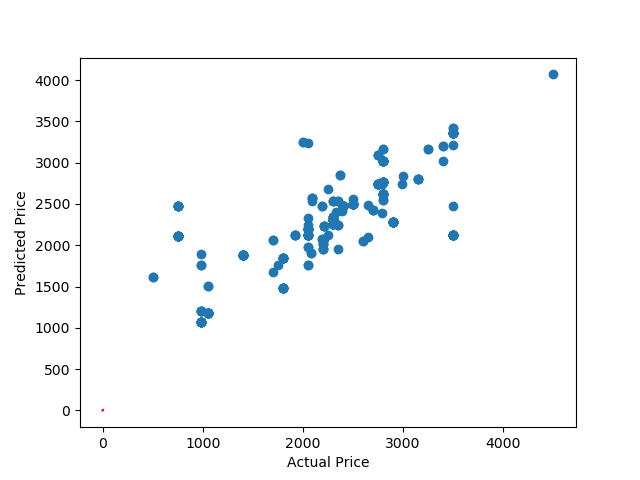

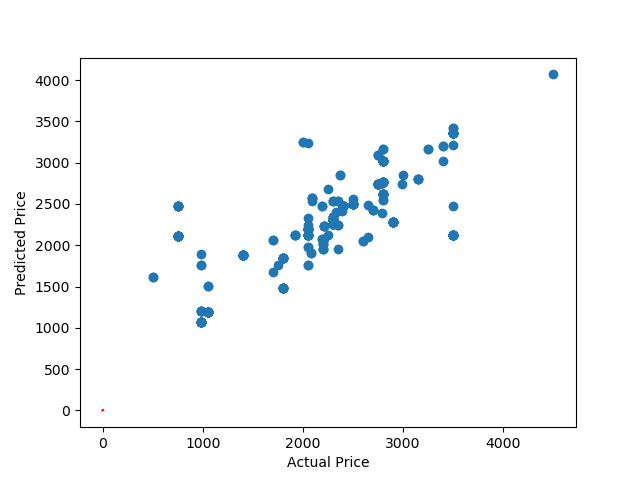

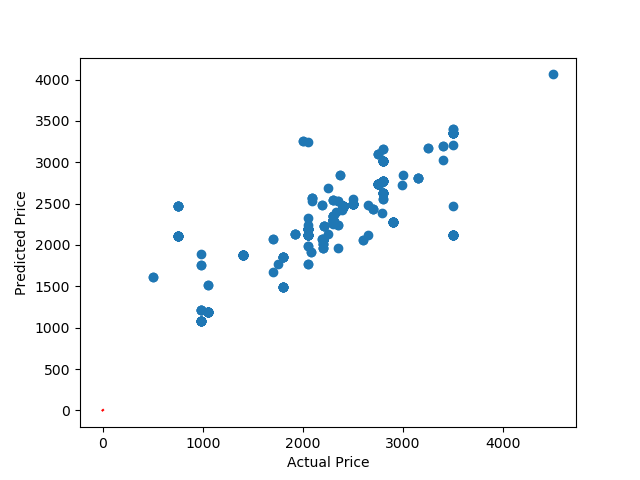

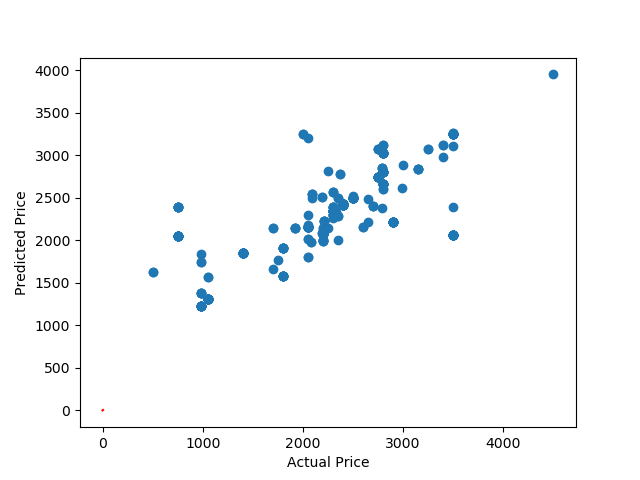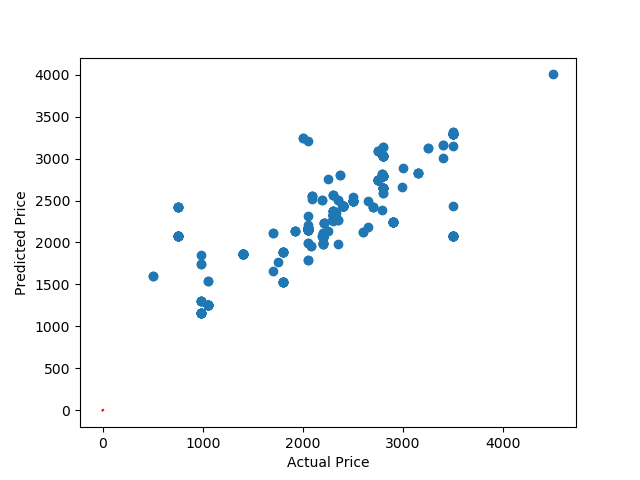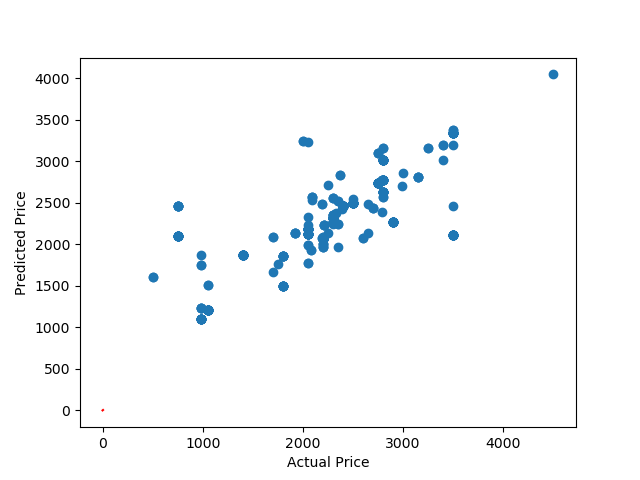

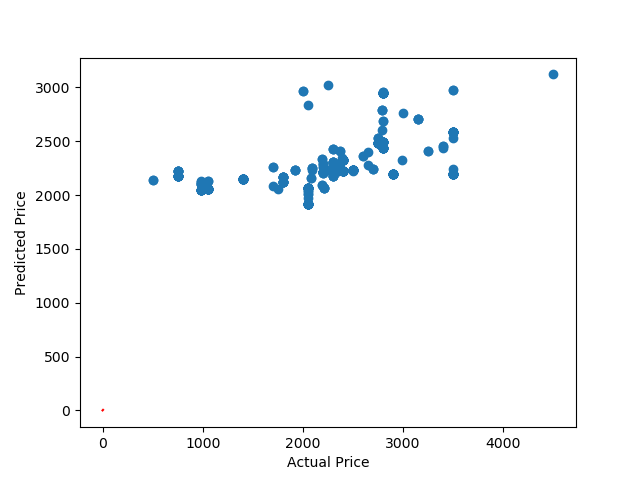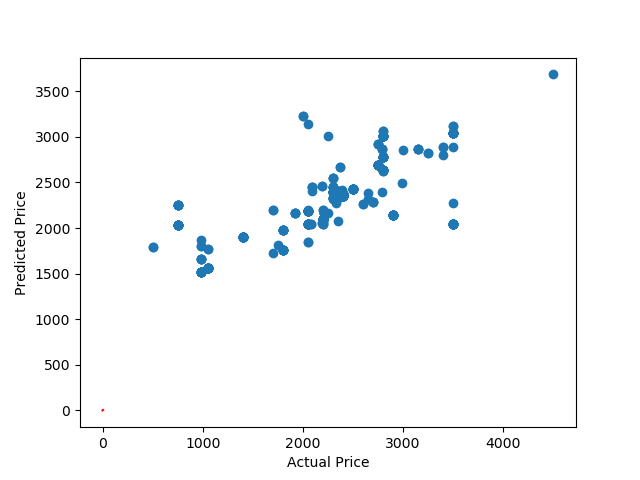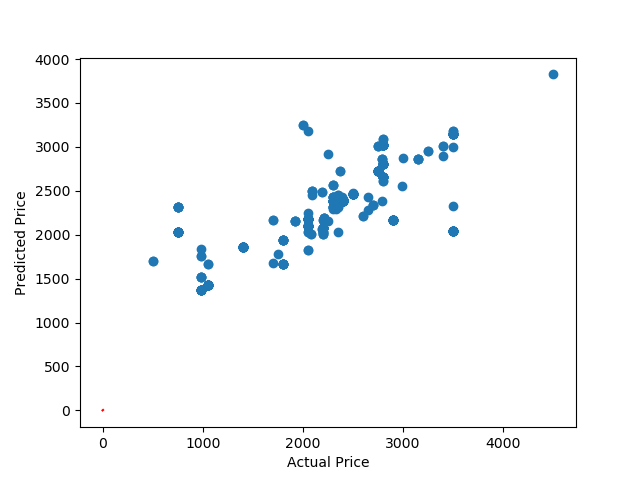

## **3.3 Discussion**

After completing the machine learning algorithm and collecting different performance metrics for each of the algorithms, the predictions can be quantifiably compared to one another. As seen in the results, the normal linear regression model outperformed the Ridge variation regression model. When looking at the performance metrics of the normal linear regression model, it can be seen that mean absolute error is 283.7 and the squared error is 239748.8. A simpler explanation of the result is that on average the prediction model is off by about 284 dollars. Overall, this can be seen as a slightly inaccurate model due to the reasoning that it often predicts the price incorrectly by a few hundred dollars. As a result, the model gives a good estimate of the price; however, it is not extremely accurate in giving a price value to the dollar. One of the reasons that this inaccuracy of the model is occurring is due to the amount of data that was used within the model and the quality of the data. It was noticed that the housing prices in Toronto are extremely expensive and vary in value significantly depending on the location. With data points that vary in value significantly and have similar features, these could confuse the linear regression model when training. 

One of the most important aspects of the project was to compare different linear regression variations to attempt to increase prediction accuracy of the model. This was accomplished through the parameter tuning of the linear regression variation Ridge by tweaking the alpha parameter value. As seen in the results, the alpha value was slowly increased to assess the overall performance of the prediction model. It was noticed that very small alpha values had little to no impact on the model since the error values changed by an insignificant amount (got worse). When the alpha values were increased significantly, such as an alpha value of 20 or 50, the error values were significantly higher than the normal linear regression model. This was one of the indicators that the Ridge variation performed much worse than the normal linear regression model. In addition, the residual distributions gave valuable insight on the performance of the prediction model. When looking at the normal linear regression residual distribution plot, there were a significant amount of data points that were predicted with a residual close to zero. Since the residuals were close to zero, this reflects that the prediction was very accurate and not off by a significant dollar value. In addition, the distribution has a symmetrical shape with fewer predictions with larger residuals indicating that overall predictions are good. The issue was that when alpha was increased, this resulted in residual distributions that had fewer values with small residuals and significantly more values at higher residuals. This result matches the prior claim that increasing alpha resulted in a worse performing prediction algorithm. Lastly, it was noticed that small alpha values resulted in performance results that were similar to the normal linear regression model. As stated previously, when alpha is close to zero the model behaves similarly to normal linear regression which is confirmed by the performance results. The coefficient results will be explained in more detail in the insights section since they provide important pricing information.

## **3.4 Outliers**

One of the more surprising results that was found throughout running the linear regression model is that the all female units weighting factor. The weighting for this feature always turns out to be a negative number with a significantly large magnitude. This means that all female units cause the rent prices to decrease significantly in the Toronto area. One of the explanations behind this could be that lowering the rent prices of female students could help encourage female university students to room together since this might be a preference from the landlord. In addition, this could also be a bias of our data in which the only female units have lower rental prices than usual and are few in numbers. 


Another surprising result that was found relates to the Ridge variation that was used to attempt to increase the performance of the prediction. In numerous articles, it was explained that increasing the alpha parameter would lead to better results in the predictions. The interesting result found during testing the Ridge variation was that increasing alpha had actually led to worse results in predictions. This can be seen by the residual distribution plots due to the reasoning that there are a great amount of large residuals at large price values. With this result, it means that the Ridge with high alpha values were making a significant amount of predictions that were inaccurate by several hundred dollars. This reasoning is also supported by the large in magnitude error calculated with an alpha value of 100 having a mean absolute and squared error of 351.7 and 281757.7 respectively. These large values in the error calculations result in the conclusion that the Ridge algorithm performed worse than the normal linear regression model with large alpha values.




# **4. Conclusion**

## **4.1 Insights**

The correlation coefficients when alpha is 1 (where the mean squared error is the minimum) are tabulated below:

|Features | Correlation Coefficients |
| ----- | ----- |
|area                 |      0.887942|
|distance_to_POI:campus  |  42.360647|
|distance_to_POI:grocery | -86.358936|
|female_only             |-636.349810|
|furnished               | -68.448555|
|gym                    |  316.469775|
|in_unit_laundry         | 264.852898|
|num_bathrooms          |  166.789153|
|num_bedrooms            | 426.785769|
|parking               |   154.367883|
|utilities_included    |   307.994860|

From this table, it is obvious that `female_only`, `gym`, `num_bedrooms`, `num_bathrooms`, `in_unit_laundry`, `utilities_included`, and `parking` are the top features that are most relevant to the housing price in Toronto, all of which have a coefficient greater than 100 (or smaller than -100).

For `gym`, `num_bathrooms`, `in_unit_laundry`, `parking`, and `utilities_included`, it makes sense that these features contributes to the increase of the housing price since they are all benefits for the students.

Other features, however, can not be easily explained with reasonable analysis. For example, more bedrooms mean more people, which should be a reason for a lower price (negative coefficient), but the actual coefficient found in the table is positive.

One possible reason for this is that there are some underlying, more prominent features like "distance to shopping centres" that were not considered by this project.

## **4.2 Application**

After developing a machine learning tool to accurately predict the outcome of rental prices, the group realized that the tool is extremely useful for university students. In particular, the Toronto area was investigated; however, this type of issue applies to every single university student that is looking for short term housing. Currently, students do not have insight or factual evidence to counter rental housing listings resulting in landlords taking advantage of the student population. With this newly developed tool, students now have the ability to investigate rental pricings to see if they are charged unfairly on a rental unit. Another interesting consequence from the developed tool is that students can gain more insight regarding what makes certain rental units more expensive when compared to others. An example would be to explore the relationship between the distance to campus and the pricing of the rental unit. As a result, students can better assess how their preferences in features of housing impacts the end price they are paying for the unit. With this in mind, students have the capability to make better financial decisions since they are aware exactly how certain features impact the pricing of houses. This is similar to the concept of explainable AI in which students can gain insight regarding the algorithm's decision making process to aid in their own decision making for rental units.


## **4.3 Key Learnings**

There were many valuable lessons that were found when completing the machine learning tool to predict housing prices. Arguably the most important lesson was that a machine learning algorithm is only as good as its database. At first, the group was having difficulties with obtaining data since chat GPTs API limited the speed at which data was obtained. As a result, around 100 data points were collected and tested which led to extremely inaccurate predictions from training the linear regression model. Some of the issues with the initial database was that the data was not cleaned properly and held incorrect or missing fields. Contributing to the issues was that 100 data points was not enough to accurately train the model. The group quickly learned from these issues and increased the database to approximately 10 times (999 points) and cleaned all of the fields of the individual data points as specified earlier in the report. With a significantly better dataset, the predictions of the rental prices were much more accurate. 

Another important lesson is that there is not a singular machine learning algorithm that is best suited for each problem. The group initially implemented a normal linear regression model for the rental housing price predictor tool. As stated previously in the report, many other variations of linear regression were investigated and parameter tuning could be accomplished depending on the method and the problem at hand. The final lesson was that through extensive research of different variations of linear regression, parameters could be adjusted to increase the performance of the prediction model. Lastly, even though other variations were explored there were significantly more machine learning algorithms that could be implemented and tested to see if the performance is increased.


## **4.4 Future Progress**

When thinking of the next steps or the project, they will be centered around making the tool more accessible to the public. One of the easiest ways to make the tool accessible would be to create a website in which the project can be hosted on. After being provided the link to the website, the user will have the ability to manually enter different fields that are related to the features explored in the project. The website will be as user friendly as possible with all fields clearly laid out and an overall description of the purpose of the tool being highlighted. Once the user inputs all relevant fields, the algorithm will run and output a predicted price for the criteria. Aside from creating a website, another possibility would be to develop a mobile app that functions similarly to the website. A significant majority of the population has access to a mobile device making an app perfect for making the tool widely accessible to the general public.

Although most of the future steps include making the tool accessible to the public users, there are some modifications that can be made to the tool to improve performance. This includes using different algorithms to see if the performance of the prediction can be improved. In particular, after some research it was found that the k-NN or Random Forest algorithms have been found to be the most suitable for creating a prediction model for house prices [5]. In the future, these algorithms can be fully explored to see if they perform better than the linear regression model used in the project. 


# **5. Bibliography**

[1] Black, K. (2022, February 3). Web-scraping kijiji ads with python. Medium. Retrieved April 4, 2023, from https://medium.com/@kaineblack/web-scraping-kijiji-ads-with-python-ef81a49e0e9e

[2] Sklearn.linear_model.Ridge. scikit. (n.d.). Retrieved April 6, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge 

[3] Sklearn.linear_model.lasso. scikit. (n.d.). Retrieved April 6, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso 

[4] Sklearn.linear_model.ElasticNet. scikit. (n.d.). Retrieved April 6, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet 

[5] Predicting House prices with machine learning methods - diva portal. (n.d.). Retrieved April 6, 2023, from https://www.diva-portal.org/smash/get/diva2:1354741/FULLTEXT01.pdf 